In [1]:
from __future__ import division

import os
import pandas as pd                     # library to handle data even from spreadsheets 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as mticker

import scipy.integrate as integrate
from scipy import interpolate
from scipy.interpolate import griddata  # useful for not-regular grid points
import scipy.special as bessel
import scipy.optimize as opt
from scipy.optimize import curve_fit

import sys
import pylab
import time
from tqdm.notebook import tqdm

In [2]:
###############
# LaTeX block #
###############

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})
rc('xtick', labelsize=18)
rc('ytick', labelsize=18)
rcParams['legend.numpoints'] = 1

In [59]:
def plot_cosmetics_single():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=18)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=18)
    ax.xaxis.set_tick_params(pad=7)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 15
    
    
def plot_cosmetics_multi():
    ax = plt.gca()
    ax.tick_params(direction='in', axis='both', which='major', length=6.8, width=1.2, labelsize=20)
    ax.tick_params(direction='in', axis='both', which='minor', length=3.3, width=1.2, labelsize=20)
    ax.xaxis.set_tick_params(pad=10)
    ax.xaxis.labelpad = 5
    ax.yaxis.labelpad = 10

In [60]:
########################################################
# CONSTANTS: physical constants and conversion factors #
########################################################

c2kB = 6.50966198               # divided by 10^36
pc_mt = 3.0857e+16              # parsec in meters
pc_cm = 3.0857e+18              # parsec in centimeters
m_to_pc = pow(pc_mt,-1)         # to pass from meters to parsec
cm_to_pc = 3.24 * pow(10,-19)   # to pass from centimeters to parsec
conv_factor_GeV_to_erg = 0.00160218   # the value in [GeV] has to be multipled by this factor
conv_factor_erg_to_GeV = 624.151
conv_factor_yr_to_sec = 31.56*pow(10,6)
conv_GeV_g = 1.78e-24

m_p = 0.939                     # proton mass in GeV/c^2
m_e = 0.000510998918            # electron mass in GeV/c^2
c = 2.99*pow(10,10)             # speed of light in [cm sec^(-1)]
c_pcSec = c * cm_to_pc          # same, in [pc sec^{-1}]

# <center> Plasma parameters

$$
\begin{aligned}
&\bullet \; \; x_c \equiv \left( \frac{6 \rho M_A^2 L_{\mathrm{inj}} v_A}{\eta_0} \right)^{2/3} \\
&\bullet \; \; \rho = n_{\mathrm{ISM}} \cdot m_p, \qquad \eta_0 = 6 \cdot 10^{3} \, \left( \frac{37}{\mathrm{ln} \, \Lambda} \right) \left( \frac{T_{\mathrm{ISM}}}{10^8 \, \mathrm{K}} \right)^{5/2} \frac{\mathrm{g}}{\mathrm{cm \cdot s}} \; \left( \mathrm{Spitzer} \, 1962 \right), \qquad \mathrm{ln} \, \Lambda \equiv \mathrm{ln} \, \left( \frac{b_{\mathrm{max}}}{b_{\mathrm{min}}} \right) \simeq \mathrm{ln} \, \left( \frac{\lambda_D}{b_{\mathrm{min}}} \right), \, b_{\mathrm{min}} \approx 8.63 \cdot 10^{-8} \left( \frac{10^4 \, \mathrm{K}}{T_{\mathrm{ISM}}} \right) \, \mathrm{cm} \\
&\bullet \; \; \lambda_D \approx 0.95 \cdot 10^5 \cdot \left( \frac{T}{10^6 \, \mathrm{K}} \right)^{1/2} \left( \frac{10^{-3} \, \mathrm{cm}^{-3}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm} \\
&\bullet \; \; \beta = 3.3 \cdot \left( \frac{3 \, \mu\mathrm{G}}{B_{\mathrm{Cyg}}} \right)^2 \left( \frac{n_{\mathrm{ISM}}}{1 \, \mathrm{cm^{-3}}} \right) \left( \frac{T_{\mathrm{ISM}}}{10^4 \, \mathrm{K}} \right) \\
&\bullet \; \;  v_A = 6.27 \cdot 10^5 \, \left( \frac{B_{\mathrm{Cyg}}}{3 \, \mu\mathrm{G}} \right) \left( \frac{1 \, \mathrm{cm^{-3}}}{n_{\mathrm{ISM}}} \right)^{1/2} \, \mathrm{cm \cdot s^{-1}}
\end{aligned}
$$

In [69]:
################################
### Environmental parameters ###
################################

gamma_ratio = m_p/m_e
WIM_size = 900.               # in [pc]
Halo_size_minus_WIM = 5100.   # in [pc]


B_field = 10.         # magnetic field, in [muGauss]
n_ISM = 0.1           # density of the environment, in [cm^{-3}]
T_ISM = 5.e3          # in [K]

L_disk = 10.              # in [pc]
M_A_disk = 1.             # Alfvénic Mach Number


###
v_A = 6.27e5 * (B_field / 3.) * (1. / n_ISM)**(1/2)                       # in [cm sec^{-1}]
v_A_pcSec = v_A * cm_to_pc                                                # in [pc sec^{-1}]
rho = n_ISM * (m_p * conv_GeV_g)
Debye_length = 0.95e5 * (T_ISM / 1.e6)**(1/2) * (1.e-3 / n_ISM)**(1/2)    # in [cm]

b_min = 8.63e-8 * (1.e4 / T_ISM)                                          # in [cm]
ln_Lambda = np.log(Debye_length / b_min)
eta_0 = 6.e3 * (37 / ln_Lambda) * (T_ISM / 1.e8)**(5/2)  # in [g cm^{-1} s^{-1}]


x_c = ( (6 * rho * M_A_disk**2 * (L_disk*pc_cm) * v_A) / (eta_0) )**(2/3)
beta_disk = 3.3 * (3. / B_field)**2 * (n_ISM / 1.) * (T_ISM / 1.e4)
###


print('rho =', rho, '[g]')
print('v_A =', v_A / 1.e5, '[km s^{-1}]')
print('ln_Lambda =', ln_Lambda)
print('x_c =', x_c)
print('plasma beta =', beta_disk)

rho = 1.67142e-25 [g]
v_A = 66.09160309751913 [km s^{-1}]
ln_Lambda = 22.0821774526117
x_c = 1098163.8954614
plasma beta = 0.01485


# <center>Truncation Scale (Petrosian $et \;al.$ 2006 ApJ 644 603)
    
### Collisionless damping

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \frac{4 \, M_A^4 \, \gamma \, \xi^2}{\pi \, \beta \, (1 - \xi^2)^2} \, e^{\frac{2}{\beta \, \gamma \, \xi^2}}\\[10pt]
&\gamma = \frac{m_p}{m_e}, \; \beta = \frac{P_g}{P_B}
\end{align}$$

### Collisional damping (viscous)

$$\begin{align}
&k_{\mathrm{max}} L_{\mathrm{inj}} = \begin{cases}
    x_c \, (1 - \xi^2)^{-2/3} & \beta \ll 1\\
    x_c \, (1 - 3 \, \xi^2)^{-4/3} & \beta \gg 1
  \end{cases}\\[10pt]
&x_c =  \left( \frac{6 \, \rho \, \delta V^2 \, L_{\mathrm{inj}}}{\eta_0 \, v_A} \right)^{2/3} = \left( \frac{6 \, \rho \, M_A^2 \, L_{\mathrm{inj}} \, v_A}{\eta_0} \right)^{2/3}
\end{align}$$

In [6]:
path_plots = '/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots_GSSI/'

In [63]:
p_CR = np.logspace(-1, 5, num=60)

p_CR_chosen = [1.e2, 1.e4]  # in [GeV]
indx_p_CR = [np.argmin( abs(p_CR - p_CR_chosen[i]) ) for i in range(len(p_CR_chosen))]


def Larmor_radius(p_, B_):
    # with p in [GeV] and B in [muG], the result is in [cm], and [pc]
    return 3.31e+12 * (p_ / 1.) * (1. / B_), 3.31e+12 * (p_ / 1.) * (1. / B_) * cm_to_pc


def LarmorToMomentum(r_L_, B_):
    # with r_L in [cm] and B in [muG], the result is in [GeV]
    return 3.021e-13 * (r_L_ / 1.) * (B_ / 1.)



ell_inverse = np.logspace(start=1., stop=10., num=700)
kL_list = [L_disk / ell_inverse[ik] for ik in range(len(ell_inverse))]
indx_result_100GeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[0]], B_field)[1] - kL_list) )
indx_result_10TeV = np.argmin( abs(Larmor_radius(p_CR[indx_p_CR[1]], B_field)[1] - kL_list) )


print(f'indx 100GeV: {indx_result_100GeV}, indx 10TeV: {indx_result_10TeV}')
print(f'kL (100GeV) = {ell_inverse[indx_result_100GeV]}')

indx 100GeV: 390, indx 10TeV: 232
kL (100GeV) = 1050652.8126116833


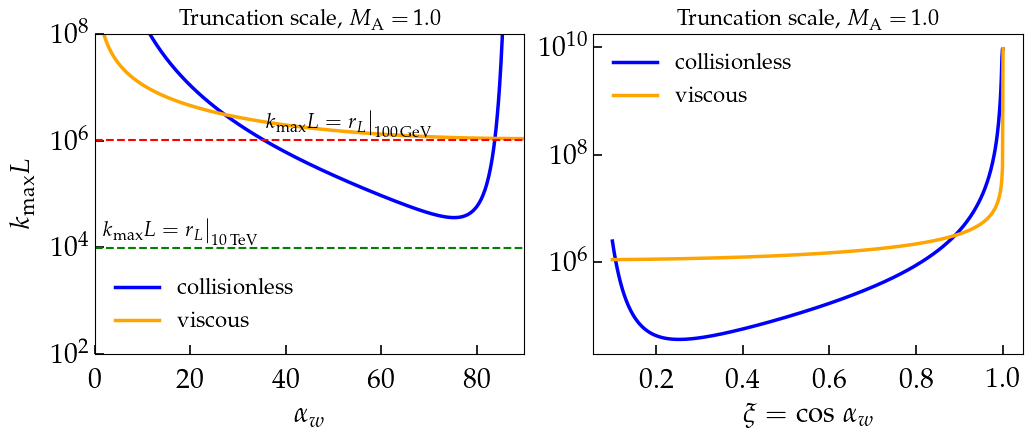

In [18]:
##################################################
### Calculate the truncation scale for damping ###
##################################################

max_kL = L_disk / Larmor_radius(1.e-2, B_field)[1]    # maximum kL, resonating with 10^{-2}GeV CRs


# collisionless
def kmaxL_coll( alpha_ ):
    numerator = 4. * M_A_disk**4 * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2
    denominator = np.pi * beta_disk * ( np.sin( np.radians(alpha_) ) )**4
    exp = np.exp( 2. / ( beta_disk * gamma_ratio * ( np.cos( np.radians(alpha_) ) )**2 ) )
    return numerator / denominator * exp

def kmaxL_coll_xi( cosAlpha_ ):
    numerator = 4. * M_A_disk**4 * gamma_ratio * ( cosAlpha_ )**2
    denominator = np.pi * beta_disk * ( 1 - cosAlpha_**2 )**2
    exp = np.exp( 2. / ( beta_disk * gamma_ratio * ( cosAlpha_ )**2 ) )
    return min(max_kL, numerator / denominator * exp)


# collisional (viscous)
def kmaxL_visc( alpha_ ):
    return x_c * ( np.sin( np.radians(alpha_) ) )**(-4/3)

def kmaxL_visc_xi( cosAlpha_ ):
    return min(max_kL, x_c * ( 1 - cosAlpha_**2 )**(-2/3))



num_alpha = 700
alpha = np.linspace(start = 0., stop = 90., num = num_alpha)    # wave pitch-angle in degrees
cosAlpha = np.linspace(start = 0.1, stop = 1., num = num_alpha)


plt.figure(figsize=(10.5, 4.5))
plt.subplot(1, 2, 1)
plot_cosmetics_multi()

plt.plot(alpha, kmaxL_coll(alpha), lw=2.5, color='blue', label='collisionless')
plt.plot(alpha, kmaxL_visc(alpha), lw=2.5, color='orange', label='viscous')
plt.axis([0.,90., 1.e2,1.e8])
plt.axhline(y=ell_inverse[indx_result_100GeV], ls='--', lw=1.5, color='red')
plt.axhline(y=ell_inverse[indx_result_10TeV], ls='--', lw=1.5, color='green')
plt.text(0.4, 0.703, '$k_{\mathrm{max}}L = r_L \\big|_{100 \, \mathrm{GeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.text(0.02, 0.366, '$k_{\mathrm{max}}L = r_L \\big|_{10 \, \mathrm{TeV}}$', fontsize=15, transform = plt.gca().transAxes)
plt.title('Truncation scale, $M_{\mathrm{A}} = \,$' + str(M_A_disk), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\alpha_w$',fontsize=20)
plt.ylabel('$k_\mathrm{max}L$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.plot(cosAlpha, [kmaxL_coll_xi(i) for i in cosAlpha], lw=2.5, color='blue', label='collisionless')
plt.plot(cosAlpha, [kmaxL_visc_xi(i) for i in cosAlpha], lw=2.5, color='orange', label='viscous')
plt.title('Truncation scale, $M_{\mathrm{A}} = \,$' + str(M_A_disk), fontsize=16, loc='center', pad=None)
plt.xlabel('$\\xi = \mathrm{cos} \; \\alpha_w$',fontsize=20)
plt.yscale('log')
plt.legend(fontsize=16, frameon=False, loc='best')
plt.tight_layout()


# <center>Diffusion Coefficient

### $D_{\mu \mu}$ for fast-modes TTD

$$\begin{align}
&D^{T}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \\[10pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{align}$$

### $D_{\mu \mu}$ for fast-modes Gyroresonance

$$D^{G}_{\mu \mu} \, \frac{L}{v} = \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \sum^{+\infty}_{n=-\infty} J_n^{'2}(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} }$$

$$(D^{G, n=+1}_{\mu \mu} + D^{G, n=-1}_{\mu \mu}) \cdot \frac{L}{v} = \frac{M_A^{3/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 R^2} \, \int^1_0 d \xi \int^{k_{max}L(\xi)}_1 dx \, \xi \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, x^{-5/2} \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x \, R \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \right) $$

### $D_{\mu \mu}$ for Alfvén modes
### $(M_A \leq 1)$

$$ D^A_{\mu \mu} = \frac{2 v M^{4/3}_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)}$$

$$\begin{align}
&\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{5/6} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A^{4/3} x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)  \\[10pt]
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{-2}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} = 1, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$

### $(M_A > 1)$

$$
D^A_{\mu \mu} = \frac{2 v M_A \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 L R^2 M_A^{1/2}} \, \int d x_{\parallel} \int d x_{\perp} \sum_{n=-\infty}^{+\infty} \frac{n^2 \, J^2_{n}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{-\left( \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} + \frac{ \left( \mu \, + \, \frac{n}{x_{\parallel} R} \right)^2}{M_A \, (1 - \mu^2)}  \right)} $$

$$\left( D^{A, \, n=+1}_{\mu \mu} + D^{A, \, n=-1}_{\mu \mu} \right) \cdot \frac{L}{v} = \frac{2 M_A^{1/2} \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{3 R^2} \, \int d x_{\parallel} \int d x_{\perp} \frac{J^2_{1}(\omega)}{\omega^2} \cdot \frac{x_{\perp}^{-7/3}}{x_{\parallel}} \cdot e^{- \frac{x_{\parallel}}{M_A x_{\perp}^{2/3}} } \left( e^{-\frac{ \left(\mu \, + \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } + e^{-\frac{ \left(\mu \, - \, \frac{n}{x_{\parallel} \, R}\right)^2 }{(1 - \mu^2) M_A} } \right)$$

$$\begin{align}
&x_{\perp, min} \equiv k_{\perp, min} \ell_{\mathrm{tr}} = 1 \, \Rightarrow \, x_{\perp, min} = k_{\perp, min} \cdot \left( \frac{\ell_{\mathrm{tr}}}{L} \right) L = 1 \, \Rightarrow \, {\color{red}x_{\perp, min}} = \frac{1}{\left( \frac{\ell_{\mathrm{tr}}}{L} \right)} \approx M_A^{3}, \\ 
&x_{\perp, max} \equiv k_{\perp, max} L \gg r^{-1}_L|_{_{E_{min}}} L  \quad \Rightarrow \quad {\color{blue}x_{\perp, max}} = 10^2 \cdot 3 \cdot 10^{-11} \mathrm{cm}^{-1} L \, @ \, E_{min} = 10^{-2} \, \mathrm{GeV}\\[10pt]
&\color{red}x_{\parallel, min} \approx M_A^{3}, \qquad \qquad \color{blue}x_{\parallel, max} = x_{\perp, max}^{2/3}
\end{align}$$


### <center>Condition on each $\mu$ for diffusive regime
    
$$\left( \frac{2  D_{\mu \mu}}{1 - \mu^2} \right)^{-1} \cdot c \equiv \Delta x < \frac{L_{\mathrm{H,D}}}{5}$$


### <center>Final Integral
    
$$D(R) = \frac{1}{4} \int_{0}^{\mu^*} d\mu \, \frac{v^2 \, (1 - \mu^2)^2}{D^{f,T}_{\mu \mu}  + D^{f,G}_{\mu \mu} + D^{A,G}_{\mu \mu}}$$

## <center> Resonance functions
    
### Fast modes    

$$
\begin{aligned}
&\mathcal{R}_n \left( k_\parallel, \Omega \right) = \frac{\sqrt{\pi}}{\sqrt{2} \, |k_\parallel| v_\perp \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/4}} \cdot \mathrm{exp} \left[ { -\frac{ \left(k_\parallel v_\parallel - \omega \pm n\Omega \right)^2 }{2 k_\parallel^2 v_\perp^2 \left( \frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \right)^{1/2} } } \right] =  
\begin{cases}
\mathcal{R}_0 = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, - \, \frac{v_A}{\xi v_{\mathrm{CR}}} \right)^2}{2 (1 - \mu^2)M_A}  } & n=0\\[6pt]
\mathcal{R}_{\pm 1} = \frac{L \sqrt{\pi}}{\sqrt{2} x |\xi| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x \xi R} \right)^2}{2 (1 - \mu^2)M_A}  } & n=\pm 1
\end{cases}\\[10pt]
&\frac{ \left\langle\delta  B_\parallel^2\right\rangle }{B_0^2} \equiv M_\mathrm{A}^2
\end{aligned}
$$
    
    
### Alfvén modes
$$
\begin{aligned}
\mathcal{R}_{\pm 1} = \frac{L \sqrt{\pi}}{\sqrt{2} |x_\parallel| v_{\mathrm{CR}} (1 - \mu^2)^{1/2} M_A^{1/2}} \cdot e^{ -\frac{\left( \mu \, \pm \, \frac{1}{x_\parallel R} \right)^2}{2 (1 - \mu^2)M_A}  }
\end{aligned}
$$

## <center> Diffusion coefficient

### $D_{\mu \mu}$ for fast-modes TTD $(n=0)$

$$\begin{align}
D^{T}_{\mu \mu} \, \frac{L}{v_{\mathrm{CR}}} &= \frac{M_A^2 \sqrt{\pi} \, (1 - \mu^2)^{1/2}}{2 \sqrt{2} R^2 M^{1/2}_A} \, \int^1_0 d \xi \int^{k_{\mathrm{max}}L(\xi)}_1 dx \, \xi \, J_1^2(\omega) \, x^{-5/2} e^{-\frac{ \left(\mu \, - \, \frac{v_A}{c \, \xi}\right)^2 }{(1 - \mu^2) M_A} } \\[10pt]
&= \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, J_1^2(\omega) \, \mathcal{R}_0(\mu, \xi, x, R) \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \\[10pt]
&\begin{cases}
&I^{\mathrm{F}}(x) = \frac{M_A^2 L^{-1/2}}{8\pi} \, k^{-7/2} \quad \rightarrow \quad I^{\mathrm{F}}_{\mathrm{norm}}(x) = \frac{M_A^2 L^{3}}{8\pi} \, (kL)^{-7/2} \\[6pt]
&\omega = R \, x \, (1 - \xi^2)^{1/2} (1 - \mu^2)^{1/2}, \quad R = \frac{r_L}{L}
\end{cases}
\end{align}$$

$$
$$
### $D_{\mu \mu}$ for fast-modes Gyro $(n \neq 0)$

$$
\left( D^{\mathrm{Gyro},\, n=1}_{\mu \mu} + D^{\mathrm{Gyro}, \, n=-1}_{\mu \mu} \right) \frac{L}{v_{\mathrm{CR}}} = \frac{4 \pi \, v_{\mathrm{CR}} (1 - \mu^2)}{L^{4}R^2} \cdot \int_0^1 d\xi \, \xi^2 \int_1^{k_{\mathrm{max}}L(\xi)} dx \, x^2 \, \left( \frac{J_0(\omega) - J_2(\omega)}{2} \right)^2 \, I^{\mathrm{F}}_{\mathrm{norm}}(x) \, \left\{ \mathcal{R}_{+1}(\mu, \xi, x, R) + \mathcal{R}_{-1}(\mu, \xi, x, R) \right\}
$$

In [42]:
## Define useful functions ##


# Resonance functions
def resonance_fast( x_, xi_, mu_, R_, n_ ):
    factor = L_disk * np.sqrt(np.pi) / ( np.sqrt(2) * x_ * np.abs(xi_) * c_pcSec * np.sqrt( (1 - mu_**2) * M_A_disk ) )
    exp_n0 = np.exp( - ( mu_ - v_A_pcSec / (xi_ * c_pcSec) )**2 / ( 2 * (1 - mu_**2) * M_A_disk ) )
    exp_nPlus1 = np.exp( - ( mu_ + 1. / (x_ * xi_ * R_) )**2 / ( 2 * (1 - mu_**2) * M_A_disk ) )
    exp_nMinus1 = np.exp( - ( mu_ - 1. / (x_ * xi_ * R_) )**2 / ( 2 * (1 - mu_**2) * M_A_disk ) )
    if n_ == 0:
        return factor * exp_n0
    elif n_ == 1:
        return factor * exp_nPlus1
    elif n_ == -1:
        return factor * exp_nMinus1


def resonance_alf( x_para_, mu_, R_, n_ ):
    numerator = L_disk * np.sqrt(np.pi)
    denominator = np.sqrt(2) * x_para_ * c_pcSec * np.sqrt( (1 - mu_**2) * M_A_disk )
    exp_nPlus1 = np.exp( - ( mu_ + 1. / (x_para_ * R_) )**2 / ( 2 * (1 - mu_**2) * M_A_disk ) )
    exp_nMinus1 = np.exp( - ( mu_ - 1. / (x_para_ * R_) )**2 / ( 2 * (1 - mu_**2) * M_A_disk ) )
    if n_ == 1:
        return numerator / denominator * exp_nPlus1
    elif n_ == -1:
        return numerator / denominator * exp_nMinus1
    
    
    
# For the calculation of the D_mumu
def fast_spectrum_norm( x_ ):
    return M_A_disk**2 * L_disk**3 / ( 8 * np.pi ) * x_**(-7/2)

def factor_FastModes( mu_, R_ ):
    return ( 4 * np.pi * c_pcSec * (1 - mu_**2) ) / ( L_disk**4 * R_**2 )

def Bessel_arg( R_, x_, xi_, mu_ ):
    return R_ * x_ * np.sqrt(1 - xi_**2) * np.sqrt(1 - mu_**2)


In [79]:
case_region = 'halo'
#case_region = 'disk'

In [80]:
import warnings
warnings.filterwarnings('ignore')


########################################
### Calculate the D(R) in the Disk #####
########################################

    
# Define the integration variables #
length_energy_array = 60
length_mu_array = 30    

p_CR = np.logspace(start = -1., stop = 5., num = length_energy_array)     # CR momentum, in [GeV/c]
R = Larmor_radius(p_CR, B_field)[1] / L_disk
mu_array = np.linspace(start = 0., stop = 0.9, num = length_mu_array)   # problems with 0° pitch-angle scattering
pointsPerDecade = 10                                                      # for the integral over x


integralOverX_TTD = np.zeros( len(cosAlpha) )
integralOverX_Gyro = np.zeros( len(cosAlpha) )
integralOverCsi = np.zeros( (len(R), len(mu_array)) )
integralOverMu = np.zeros( len(R) )



for indx_R, r in enumerate(tqdm(R)):
    
    for indx_mu, mu in enumerate(mu_array):
        
        for indx_csi, csi in enumerate(cosAlpha):
            
            if case_region == 'halo':
                n_decades = round( np.log10( kmaxL_coll_xi(csi) ) )
                x_grid = np.logspace(start=0., stop=np.log10( kmaxL_coll_xi(csi) ), num=n_decades*pointsPerDecade)
            
            elif case_region == 'disk':
                n_decades = round( np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ) )
                x_grid = np.logspace(start=0., stop=np.log10( min( kmaxL_visc_xi(csi), kmaxL_coll_xi(csi) ) ), num=n_decades*pointsPerDecade)
            
            
            
            ## TTD (n=0)
            n_TTD = 0
            besselFunc_squared = bessel.jv( 1, Bessel_arg(r, x_grid, csi, mu) )**2
            resonanceFunc_TTD = resonance_fast( x_grid, csi, mu, r, n_TTD )
            turbSpectrum = fast_spectrum_norm( x_grid )
            
            integralOverX_TTD[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFunc_squared * resonanceFunc_TTD * turbSpectrum, x = x_grid, axis=-1 )
            
            
            ## Gyro (n≠0)
            n_Gyro_plus1 = 1
            n_Gyro_minus1 = -1
            resonanceFunc_Gyro = resonance_fast( x_grid, csi, mu, r, n_Gyro_plus1 ) + resonance_fast( x_grid, csi, mu, r, n_Gyro_minus1 )
            
            integralOverX_Gyro[indx_csi] = np.trapz( y = csi**2 * x_grid**2 * besselFunc_squared * resonanceFunc_Gyro * turbSpectrum, x = x_grid, axis=-1 )
            
            
        integralOverCsi[indx_R, indx_mu] = c_pcSec / L_disk * factor_FastModes(mu, r) * np.trapz( integralOverX_TTD + integralOverX_Gyro, x = cosAlpha, axis=-1 )
        #integralOverCsi[indx_R, indx_mu] = c_pcSec / L_disk * factor_FastModes(mu, r) * np.trapz( y = integralOverX_TTD, x = cosAlpha, axis=-1 )
        
    

  0%|          | 0/60 [00:00<?, ?it/s]

In [81]:
for ir in range( len(R) ):
    integralOverMu[ir] = np.trapz( y = c**2 * (1 - mu_array**2)**2 / integralOverCsi[ir,:], x = mu_array, axis=-1 )


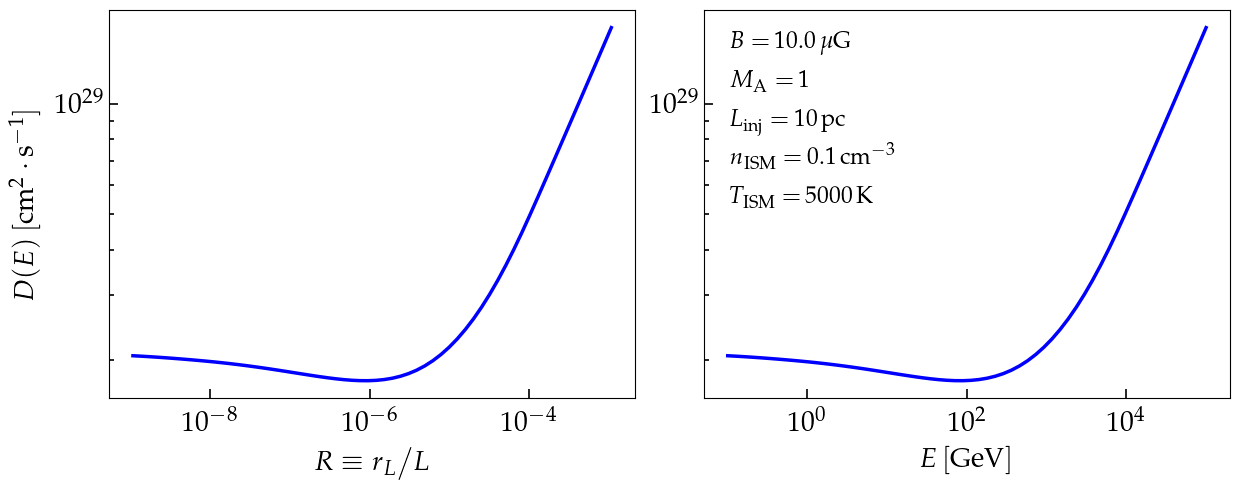

In [82]:
plt.figure(figsize=(12.5, 5.))

plt.subplot(1, 2, 1)
plot_cosmetics_multi()


plt.loglog(R, integralOverMu, lw=2.5, color='blue')
plt.xlabel('$ R \equiv r_L \\big/L$',fontsize=20)
plt.ylabel('$D(E) \, [\mathrm{cm^2 \cdot s^{-1}}]$',fontsize=20)


plt.subplot(1, 2, 2)
plot_cosmetics_multi()

plt.loglog( LarmorToMomentum(R * (L_disk*pc_cm), B_field), integralOverMu, lw=2.5, color='blue')
plt.xlabel('$ E \, [\mathrm{GeV}]$',fontsize=20)

plt.text(0.05, 0.9, '$B = \,$' + str("{:.1f}".format(B_field)) + '$\, \mu \mathrm{G}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.8, '$M_\mathrm{A} = \,$' + str("{:.0f}".format(M_A_disk)), fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.7, '$L_\mathrm{inj} = \,$' + str("{:.0f}".format(L_disk)) + '$\, \mathrm{pc}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.6, '$n_\mathrm{ISM} = \,$' + str("{:.1f}".format(n_ISM)) + '$\, \mathrm{cm^{-3}}$', fontsize=17, transform = plt.gca().transAxes)
plt.text(0.05, 0.5, '$T_\mathrm{ISM} = \,$' + str("{:.0f}".format(T_ISM)) + '$\, \mathrm{K}$', fontsize=17, transform = plt.gca().transAxes)
plt.tight_layout()


#plt.loglog(R, 5.e30 * R**0.5)

In [ ]:
########################################
### Calculate the D(R) in the Disk #####
########################################

### Calculate the D_mumu in the Disk ###

# Define the integration variables #
length_energy_array = 60
length_mu_array = 30
length_x_perp_alf_disk_array = 100       # 800/1000
length_x_parallel_alf_disk_array = 100   # 800/1000
length_x_array = 100


p_CR = np.logspace(-1, 5, num=length_energy_array)
r_L = np.zeros(len(p_CR))
R_disk = np.zeros(len(p_CR))

r_L = [3.31 * pow(10,12) / B_field * p_CR[i] for i in range(len(p_CR))]   # (p/1GeV)*(1/Z)*(10^{-6}G/B), in [cm] and c=1
R_disk = [r_L[i] / (L_disk*pc_cm) for i in range(len(p_CR))]


mu = np.linspace(0., 0.999, num=length_mu_array)          # problems with 0° pitch-angle scattering


x_perp_max_disk = r_L_inverse_minE_2ordersMore * (L_disk*pc_cm)
x_parallel_max_disk = pow(x_perp_max_disk, 2/3)


if (M_A_disk <= 1):
    x_perp_min_disk = pow(M_A_disk, -2)
    x_parallel_min_disk = 1
    
elif (M_A_disk > 1):
    x_perp_min_disk = pow(M_A_disk, 3)
    x_parallel_min_disk = pow(M_A_disk, 3)
    
        

# Fast Modes
bessel_arg_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
# TTD
bessel_func_square_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_TTD = np.zeros( (len(mu),len(csi)) )
integrand_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integral_over_x_TTD_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_TTD_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TTD_over_v_disk = np.zeros( (len(R_disk),len(mu)) )

# Gyroresonance
bessel_func_square_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
exponential_Gyro_disk_2 = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integrand_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi),length_x_array) )
integral_over_x_Gyro_disk = np.zeros( (len(R_disk),len(mu),len(csi)) )
integral_over_csi_Gyro_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Gyro_over_v_disk = np.zeros( (len(R_disk),len(mu)) )


# Alfvén modes
x_perp_alf_disk = np.logspace(np.log10(x_perp_min_disk), np.log10(x_perp_max_disk), length_x_perp_alf_disk_array) 
x_parallel_alf_disk = np.logspace(np.log10(x_parallel_min_disk), np.log10(x_parallel_max_disk), length_x_parallel_alf_disk_array) 

bessel_arg_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )
bessel_func_square_alf_disk_ratio = np.zeros( (len(R_disk),len(mu),len(x_perp_alf_disk)) )
power_alf_disk = np.zeros( (len(x_parallel_alf_disk), len(x_perp_alf_disk)) )
exponential_arg_alf_disk_first = np.zeros( (len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
exponential_arg_alf_disk_second = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_arg_alf_disk_second_2 = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
exponential_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
integrand_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk),len(x_perp_alf_disk)) )
integral_over_xperp_alf_disk = np.zeros( (len(R_disk),len(mu),len(x_parallel_alf_disk)) )
integral_over_xparallel_alf_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_Alfven_over_v_disk = np.zeros( (len(R_disk),len(mu)) )

# Total
integrand_mu_disk = np.zeros( (len(R_disk),len(mu)) )
D_mumu_TOT_disk = np.zeros( (len(R_disk),len(mu)) )
scattering_frequency_disk = np.zeros( (len(R_disk),len(mu)) )
integral_over_mu_disk = np.zeros( len(R_disk) )  
        
        
        
        



print ("Length of R array:", len(R_disk), "in the range:", min(R_disk),max(R_disk))
print ("Length of mu array:", len(mu), "in the range:", min(mu),max(mu))
print ("Length of theta array:", len(theta), "in the range:", min(theta),max(theta))
print ("Length of csi array (must be the same as theta):", len(csi), "in the range:", min(csi),max(csi))
print ("Length of kmax_L_viscous array (must be the same as theta):", len(kmax_L_reversed_visc), "in the range:", min(kmax_L_reversed_visc),max(kmax_L_reversed_visc))
print ("Length of kmax_L_collisionless array (must be the same as theta):", len(kmax_L_reversed_coll), "in the range:", min(kmax_L_reversed_coll),max(kmax_L_reversed_coll))
print('')



start_time = time.process_time()

start_advancing = time.process_time()
for r in range(len(R_disk)):
    
    print('Index:', r, '/ ' + str(length_energy_array-1) + ', R:', R_disk[r])
    
    for m in range(len(mu)):
        
        # Fast modes
        for i in range(len(csi)):

            # building the array for the integration variable x #
            x_array_disk = np.logspace(0, np.log10( min( kmax_L_reversed_visc[i],kmax_L_reversed_coll[i] ) ), num=length_x_array)
            
            power_disk = np.zeros(len(x_array_disk))

            exponential_TTD[m][i] = np.exp( - ( pow(mu[m] - v_A/(c*csi[i]),2) / ( (1 - pow(mu[m],2))*M_A_disk) ) )
            
            for j in range(len(x_array_disk)):

                bessel_arg_disk[r][m][i][j] = R_disk[r] * x_array_disk[j] * pow( (1 - pow(csi[i],2)),1/2 ) * pow( (1 - pow(mu[m],2)),1/2 )
                power_disk[j] = pow(x_array_disk[j], -5/2)

                bessel_func_square_TTD_disk[r][m][i][j] = pow(bessel.jv(1,bessel_arg_disk[r][m][i][j]),2)
                integrand_TTD_disk[r][m][i][j] = csi[i] * bessel_func_square_TTD_disk[r][m][i][j] * power_disk[j] * exponential_TTD[m][i]

                bessel_func_square_Gyro_disk[r][m][i][j] = pow( ( bessel.jv(0,bessel_arg_disk[r][m][i][j]) - bessel.jv(2,bessel_arg_disk[r][m][i][j]) )/2,2 )
                exponential_Gyro_disk[r][m][i][j] = np.exp( - (  pow(  mu[m] + 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                exponential_Gyro_disk_2[r][m][i][j] = np.exp( - (  pow(  mu[m] - 1/(x_array_disk[j] * csi[i] * R_disk[r] ) , 2 ) / ( (1 - pow(mu[m],2)) * M_A_disk) ) )    
                integrand_Gyro_disk[r][m][i][j] = csi[i] * bessel_func_square_Gyro_disk[r][m][i][j] * power_disk[j] * (exponential_Gyro_disk[r][m][i][j] + exponential_Gyro_disk_2[r][m][i][j])

            integral_over_x_TTD_disk[r][m][i] = integrate.trapz(integrand_TTD_disk[r][m][i], x_array_disk)
            integral_over_x_Gyro_disk[r][m][i] = integrate.trapz(integrand_Gyro_disk[r][m][i], x_array_disk)

        integral_over_csi_TTD_disk[r][m] = integrate.trapz(integral_over_x_TTD_disk[r][m], csi)
        integral_over_csi_Gyro_disk[r][m] = integrate.trapz(integral_over_x_Gyro_disk[r][m], csi)
        # End of the fast modes
        
        if (M_A_disk <= 1.):
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( pow(M_A_disk,4/3) * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,5/6) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]
            
        else:
            # Alfvén modes
            for p in range(len(x_parallel_alf_disk)):

                for q in range(len(x_perp_alf_disk)):

                    bessel_arg_alf_disk[r][m][q] = x_perp_alf_disk[q] * R_disk[r] * pow( 1 - mu[m]**2, 1/2 )
                    bessel_func_square_alf_disk_ratio[r][m][q] = pow(bessel.jv(1,bessel_arg_alf_disk[r][m][q]),2) / pow(bessel_arg_alf_disk[r][m][q],2)

                    power_alf_disk[p][q] = pow(x_perp_alf_disk[q], -7/3) / (x_parallel_alf_disk[p])

                    exponential_arg_alf_disk_first[p][q] = x_parallel_alf_disk[p] / ( M_A_disk * pow(x_perp_alf_disk[q],2/3) )
                    exponential_arg_alf_disk_second[r][m][p] = pow( mu[m] + 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))
                    exponential_arg_alf_disk_second_2[r][m][p] = pow( mu[m] - 1/(x_parallel_alf_disk[p] * R_disk[r]), 2 ) / (M_A_disk * (1 - mu[m]**2))

                    exponential_alf_disk[r][m][p][q] = np.exp(- exponential_arg_alf_disk_first[p][q]) * ( np.exp(- exponential_arg_alf_disk_second[r][m][p]) + np.exp(- exponential_arg_alf_disk_second_2[r][m][p]) )
                    integrand_xperp_alf_disk[r][m][p][q] = bessel_func_square_alf_disk_ratio[r][m][q] * power_alf_disk[p][q] * exponential_alf_disk[r][m][p][q]

                integral_over_xperp_alf_disk[r][m][p] = integrate.trapz(integrand_xperp_alf_disk[r][m][p], x_perp_alf_disk)

            integral_over_xparallel_alf_disk[r][m] = integrate.trapz(integral_over_xperp_alf_disk[r][m], x_parallel_alf_disk)
            # End of the Alfvén modes


            D_mumu_Alfven_over_v_disk[r][m] = ( 2 * np.sqrt(pi) * pow( 1 - mu[m]**2 , 1/2) * pow(M_A_disk,1/2) ) / (  3 * pow(R_disk[r],2) ) * integral_over_xparallel_alf_disk[r][m]


        D_mumu_TTD_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_TTD_disk[r][m]
        D_mumu_Gyro_over_v_disk[r][m] = ( pow(M_A_disk,3/2) * np.sqrt(pi) * pow( (1 - pow(mu[m],2)  ), 1/2) ) / (  2 * pow(R_disk[r],2) ) * integral_over_csi_Gyro_disk[r][m]
        
        D_mumu_TOT_disk[r][m] = (D_mumu_Alfven_over_v_disk[r][m] + D_mumu_TTD_over_v_disk[r][m] + D_mumu_Gyro_over_v_disk[r][m])*c/(L_disk*pc_cm)
        scattering_frequency_disk[r][m] = (2 * D_mumu_TOT_disk[r][m]) / (1 - mu[m]**2)
        
        if ( c/scattering_frequency_disk[r][m] <= (WIM_size*pc_cm)):
            integrand_mu_disk[r][m] = 1/8 * ( c**2 / D_mumu_TOT_disk[r][m] ) * pow( 1 - mu[m]**2 , 2 )
        else:
            # I am not filling the array "integrand_mu_disk", because it's already filled with zeros,
            # so the integral will sum only zeros
            print ("For R =", R_disk[r], ", mu =", mu[m], "generates ballistic motion")
        
    print('Advancing time:', time.process_time() - start_advancing, "seconds")
    print('')
        

print ("Length of x array:", len(x_array_disk), "in the range:", min(x_array_disk),max(x_array_disk))

print("End of the calculation of the D_mumu. It took:", time.process_time() - start_time, "seconds")

In [ ]:
### Integrate to obtain D(R) ###

for i in range(len(R_disk)):
    integral_over_mu_disk[i] = integrate.trapz(integrand_mu_disk[i], mu)
    
print (integral_over_mu_disk)

In [ ]:
# This block shows the relative contributions of the three modes #

plt.figure(figsize=(12,9))

index_energy = 59   # 5, 30, 59 

plt.plot(mu, D_mumu_TTD_over_v_disk[index_energy], lw=2, color='blue', label='Fast TTD, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Gyro_over_v_disk[index_energy], lw=2, color='red', label='Fast Gyro, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')
plt.plot(mu, D_mumu_Alfven_over_v_disk[index_energy], lw=2, color='green', label='Alfvén, $E \, = \,$'+str( "{:.2f}".format(p_CR[index_energy]) )+'$\, \mathrm{GeV}$')

plt.xlim(0., 1.)
plt.ylim(1.e-8, 1.e+3)
plt.yscale('log')

plt.legend(fontsize=20)

name_saved_pdf_D_mumu = 'D_mumu_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'_E'+str( "{:.2f}".format(p_CR[index_energy]) )+'.pdf'
plt.savefig('/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots/Parametric_study_100TeV/Scattering_efficiency_plots_100TeV/'+str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200)
#plt.savefig('/Users/ottaviofornieri/PHYSICS_projects/Diffusion_Fast_Modes/Plots/Parametric_study_correct/Scattering_efficiency_plots_correct/'+str(name_saved_pdf_D_mumu),format='pdf',bbox_inches='tight', dpi=200)


In [ ]:
### Plotting block, to study ###


plt.figure(figsize=(12,9))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


YL08_disk, = plt.plot(R_disk, integral_over_mu_disk, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')


## Fitting my curve in the requested range ##
R_disk_np = np.asarray(R_disk)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", R_disk[index_requested_energy_low], "and", R_disk[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up+1)
fitting_points = integral_over_mu_disk[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, R_disk_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

my_curve_disk, = plt.plot(R_disk_np[fitting_index_range], fit_func(R_disk_np[fitting_index_range], *popt),  color='red', lw=3, ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
plt.scatter(R_disk_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################


## Draw the asymptote ##
slope_as = 0.5

x_max = max(R_disk)
y_max = max(integral_over_mu_disk)
y_min = min(integral_over_mu_disk)

x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(R_disk), num=100)

plt.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


plt.xlabel('$R \\equiv r_L/L$',fontsize=27)
plt.ylabel('$D(R) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')


plt.legend(loc='best', frameon=False, fontsize=23)


plt.text(0.35, 0.65, r'$M_{A} = \,$'+str(M_A_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.55, r'$L_{\mathrm{inj}} = \,$'+str(L_disk)+'$\, \mathrm{pc}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.45, r'$\beta = \,$'+str(beta_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.35, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.25, r'$x_c = \,$'+str("${}$".format(f.format_data(x_c))),fontsize=23, transform = ax.transAxes)
plt.text(0.7, 0.05, 'Galactic disk', fontsize=29, transform = ax.transAxes)


name_saved_pdf = 'D_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.pdf'
plt.savefig(path_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)


In [ ]:
### Plotting block as a function of energy, to study ###


plt.figure(figsize=(12,9))


ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=27)
ax.tick_params(axis='both', which='minor', labelsize=27)
ax.xaxis.set_tick_params(pad=7)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 7


f = mticker.ScalarFormatter(useMathText=True)
f.set_powerlimits((-5,5))


plt.plot(p_CR, integral_over_mu_disk, lw=3., color='blue', label='Fornieri \\textit{et al.} (2021)')


## Fitting my curve in the requested range ##
p_CR_np = np.asarray(p_CR)

requested_energy_low = 100.  # in [GeV]
requested_energy_up = 1000.  # in [GeV]
index_requested_energy_low = np.argmin(abs(requested_energy_low - p_CR))
index_requested_energy_up = np.argmin(abs(requested_energy_up - p_CR))

print ("I am fitting the curve between", p_CR[index_requested_energy_low], "and", p_CR[index_requested_energy_up])
print (index_requested_energy_low, index_requested_energy_up)

fitting_index_range = np.arange(index_requested_energy_low, index_requested_energy_up)
fitting_points = integral_over_mu_disk[fitting_index_range]

def fit_func(x, a, b, c):
    return pow(10,28) * a * pow(x, b) + c

popt, pcov = curve_fit(fit_func, p_CR_np[fitting_index_range], fitting_points)

print ("Fit results:", popt)

plt.plot(p_CR_np[fitting_index_range], fit_func(p_CR_np[fitting_index_range], *popt),  color='red', lw=3, ls='-', label='Fit: $\delta \\simeq \,$'+ str("{:.2f}".format(popt[1])))
plt.scatter(p_CR_np[fitting_index_range], fitting_points, marker='o', s=65)
##############################################


## Draw the asymptote ##
slope_as = 0.5

x_max = max(p_CR)
y_max = max(integral_over_mu_disk)
y_min = min(integral_over_mu_disk)

x_0 = x_max / (y_max / y_min)**(1/slope_as)

x = np.linspace(start=x_0, stop=max(p_CR), num=100)

plt.loglog(x, y_min*(x / x_0)**slope_as, lw=2., ls='--', color='Orange', label='Reference: $\delta \\simeq \,$' + str("{:.2f}".format(slope_as)))
########################


plt.xlabel('$E [\mathrm{GeV}]$',fontsize=27)
plt.ylabel('$D(E) \; [\mathrm{cm}^{2} \cdot \mathrm{s}^{-1}]$',fontsize=27)
plt.xscale('log')
plt.yscale('log')


plt.legend(loc='best', frameon=False, fontsize=23)


plt.text(0.35, 0.65, r'$M_{A} = \,$'+str(M_A_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.55, r'$L_{\mathrm{inj}} = \,$'+str(L_disk)+'$\, \mathrm{pc}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.45, r'$\beta = \,$'+str(beta_disk), fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.35, r'$B_0 = \,$'+str("${}$".format(B_field))+'$\; \mu \mathrm{G}$', fontsize=23, transform = ax.transAxes)
plt.text(0.35, 0.25, r'$x_c = \,$'+str("${}$".format(f.format_data(x_c))),fontsize=23, transform = ax.transAxes)
plt.text(0.7, 0.05, 'Galactic disk', fontsize=29, transform = ax.transAxes)


name_saved_pdf = 'D_E_disk_Ldisk'+str(L_disk)+'_MA'+str(M_A_disk)+'_xc'+str(x_c)+'.pdf'
plt.savefig(path_plots + 'Diffusion_coefficients_VarB/' + str(name_saved_pdf),format='pdf',bbox_inches='tight', dpi=200)


In [ ]:
### Block to store the output D(R) in a text file ###

print (len(p_CR), len(R_disk_np), len(integral_over_mu_disk))

data_for_text_file = np.zeros( (len(p_CR), 3) )

data_for_text_file[:,0] = p_CR
data_for_text_file[:,1] = R_disk_np
data_for_text_file[:,2] = integral_over_mu_disk

print (data_for_text_file)

txt_file_name = 'D_disk_Ldisk' + str(L_disk) + '_MA' + str(M_A_disk) + '_xc' + str(x_c) + '_Bfield' + str(B_field) + '.txt'
np.savetxt(path_plots + 'Text_files_coefficients_VarB/' + txt_file_name, data_for_text_file)